In [1]:
from astropy.table import Table
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord, Angle
import fact.io as fio
from irf import irf_from_table, EffectiveArea, EnergyDispersion
from regions import CircleSkyRegion
%matplotlib inline

/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
FACT_SCATTER_AREA = (270*u.m) **2 * np.pi
T_OBS = 17.7 * u.h

N_HEGRA = (2.83e-14 / (u.GeV * u.cm**2 * u.s)).to(1/(u.TeV * u.km**2 *u.h))
INDEX_HEGRA = -2.62

N_MAGIC = ((1.5E-3)/0.001**(-2.58) / (u.TeV * u.cm**2 * u.s)).to(1/(u.TeV * u.km**2 *u.h))
INDEX_MAGIC = -2.58

print(N_MAGIC, INDEX_MAGIC)
print(N_HEGRA, INDEX_HEGRA)

982.6384636493908 1 / (h km2 TeV) -2.58
1018.8000000000001 1 / (h km2 TeV) -2.62


## Spectra

I try and forward fold some spectra here. 
Lets start by loading up some event lists.

Whats still missing:

    - Energy dispersion? Not used so far. here. 
    - Proper FACT IRF. What does it look like?
    - This interpolation business needs to be fixed properly. Need to think about edge cases.

In [3]:
dl3 = fio.read_data('../crab_dl3.hdf5', key='events')
# adapt units. CTA uses TeV everywhere. 
dl3.gamma_energy_prediction = (dl3.gamma_energy_prediction.values * u.GeV ).to('TeV').value

# make sure to use the same cut used during the generation of the IRF.
dl3_gammas = dl3.query('gamma_prediction > 0.85')

crab = SkyCoord.from_name('Crab Nebula')

# TODO why is this offset seemingly necessarry? 
ra = (dl3_gammas.ra_prediction.values + 0.005) * u.hourangle
dec = dl3_gammas.dec_prediction.values * u.deg - 0.05*u.deg
event_coordinates = SkyCoord(ra=ra, dec=dec)

### Estimate Background

We need to 'model' the background. In other words, we need the energy distribution of the events which are not in the signal region. I take a ring around the source position for that. Then I bin the events and weigh them by their respective selection area.

In [4]:
def _build_standard_wcs(image_center, shape, naxis=2, fov=9 * u.deg):
    from astropy import wcs
    width, height = shape
    
    w = wcs.WCS(naxis=2)
    w.wcs.crpix = [width / 2 + 0.5, height / 2 + 0.5]
    w.wcs.cdelt = np.array([-fov.value / width, fov.value / height])
    w.wcs.crval = [image_center.ra.deg, image_center.dec.deg]
    w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
    w.wcs.radesys = 'FK5'
    w.wcs.equinox = 2000.0
    w.wcs.cunit = ['deg', 'deg']
    w._naxis = [width, height]
    return w

spatial_bins = (100, 100)
wcs = _build_standard_wcs(crab, spatial_bins, fov=6*u.deg)

theta_cut = Angle(0.25, 'deg')
on_region = CircleSkyRegion(center=crab, radius=theta_cut)
on_region_area = on_region.to_pixel(wcs).area
m_on = on_region.contains(event_coordinates, wcs)

outter = CircleSkyRegion(center=crab, radius=Angle(0.8, 'deg'))
inner = CircleSkyRegion(center=crab, radius=Angle(0.3, 'deg')) 

bkg_region =   outter ^  inner
bkg_region_area = outter.to_pixel(wcs).area - inner.to_pixel(wcs).area
m_bkg = bkg_region.contains(event_coordinates, wcs)

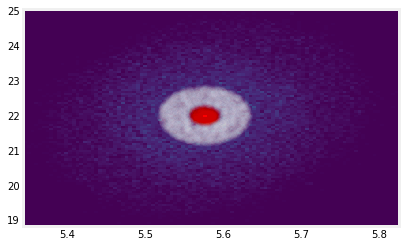

In [5]:
plt.hist2d(ra, dec, bins=spatial_bins)
plt.scatter(ra[m_on], dec[m_on], alpha=0.02, color='red')
plt.scatter(ra[m_bkg], dec[m_bkg], alpha=0.02, color='white')
# plt.scatter(crab.ra.hourangle, crab.dec.deg)
plt.grid()

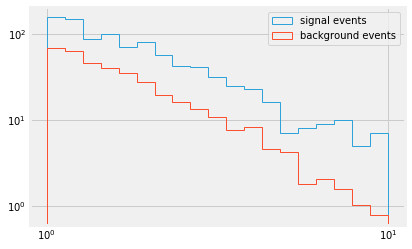

In [30]:
signal = dl3_gammas.gamma_energy_prediction[m_on]
background = dl3_gammas.gamma_energy_prediction[m_bkg]


bins=np.logspace(0, 1, 20, base=10)
bin_centers = np.sqrt(bins[0:-1] * bins[1:])
bin_widths = np.diff(bins)


# weigh the events by their respective areas
bkg_weights = np.ones_like(background) * on_region_area /bkg_region_area

plt.hist(signal, bins=bins, histtype='step', label='signal events')
plt.hist(background, bins=bins, histtype='step', label='background events', weights=bkg_weights)
plt.legend()
plt.xscale('log')
plt.yscale('log')
None

## Effective Area

Load the IRF from the fits file. We need only the effective area for now. 

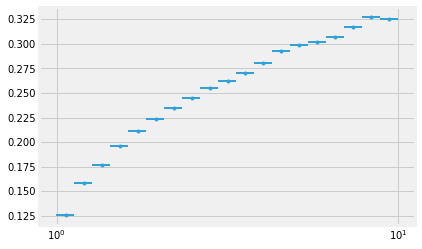

In [31]:
table = Table.read('../fact_irf.fits', hdu='EFFECTIVE AREA')
grid, data =  irf_from_table(table, interpolation_modes={'ENERG':'log'})
aeff = EffectiveArea(grid, data)

area = aeff.evaluate(bin_centers*u.TeV, theta=0*u.deg).to('km^2')

trigger_probability = (aeff.evaluate(bin_centers*u.TeV, theta=0*u.deg)/FACT_SCATTER_AREA).si.value
plt.errorbar(bin_centers, trigger_probability, xerr=bin_widths/2, fmt='.')
plt.xscale('log')

## Modeling

Well this is a 'model' for a simple power law. I was using the power_law module before. It handles units carefully. But its like super slow. And I mean __super slow__

I use the `Cash` likelihood here. No particular reason for that. Usually one would model the background somehow. Not sure this applies in this case since I can measure my background. So this might not be 100% correct.

I do one quick plot of the likelihood to see if it has a maximum.

In [32]:
def expected_events_in_bins(index, bins):
    events_per_time_and_area = np.array([expected_events_in_range(index, m, n) for m, n in zip(bins[0:], bins[1:])])
    return events_per_time_and_area

def expected_events_in_range(index, e_low, e_high):
    return (1 / (index + 1)) * (e_high**(index + 1) - e_low**(index + 1))

In [33]:
measured_counts_in_signal_region, _  = np.histogram(signal, bins=bins)
measured_bkg_counts, _  = np.histogram(background, bins=bins, weights=bkg_weights)

# these are the events we expect according to our folded model.
expected_counts = expected_events_in_bins(index=INDEX_HEGRA, bins=bins) * area * T_OBS * N_HEGRA * u.TeV 
expected_counts = expected_counts.si +  measured_bkg_counts

print(measured_counts_in_signal_region.sum(), np.nansum(expected_counts))

917 864.4576722520197


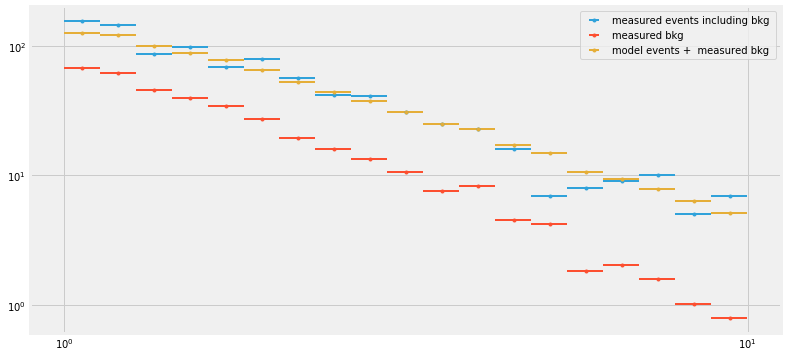

In [34]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))

ax1.errorbar(bin_centers, measured_counts_in_signal_region, xerr=bin_widths/2, fmt='.', label='measured events including bkg')
plt.errorbar(bin_centers, measured_bkg_counts,  xerr=bin_widths/2,  label='measured bkg ', fmt='.')
ax1.errorbar(bin_centers, expected_counts,xerr=bin_widths/2, fmt='.', label='model events +  measured bkg ')
ax1.legend()
ax1.set_xscale('log')
ax1.set_yscale('log')


In [35]:
def binned_poisson_likelihood(p, c_measured, c_bkg_measured, bins, areas, T_OBS):
    '''
    Physical values have no astropy units attached here for speed.
    [T_OBS] = h
    [areas] = m^2
    [bins] = TeV
    '''
    N, index = p

    if N < 100 or N > 2000:
        return -np.inf
    if index < -4 or index > -1.0:
        return -np.inf 
    
    c_expected = expected_events_in_bins(index=index, bins=bins) * T_OBS * areas * N
    M = c_expected +  c_bkg_measured

    g = c_measured*np.log(M)
    
    g[g==np.inf] = 0

    return - (np.nansum(M) - np.nansum(g))

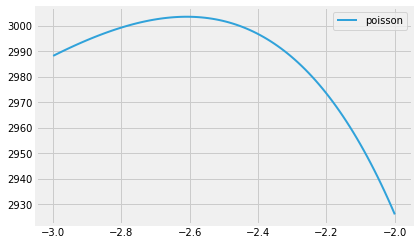

In [36]:
x = np.linspace(-2, -3, 100)
binned_poisson = [binned_poisson_likelihood((1000, i), measured_counts_in_signal_region, measured_bkg_counts, bins, area.value, T_OBS.value) for i in x]

plt.plot(x, binned_poisson, label='poisson')
plt.legend()

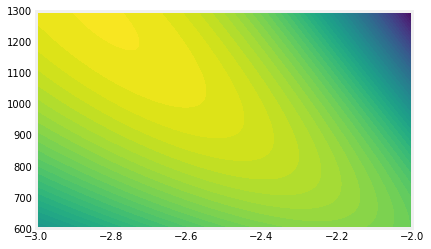

In [37]:
nx = 100
nn = 100

x = np.linspace(-2, -3, nx)
n = np.linspace(1300, 600, nn)

c = []
xv, yv = np.meshgrid(x, n, sparse=False, indexing='ij')
for i in range(nx):
    for j in range(nn):
        index, normal =  xv[i,j], yv[i,j]
        c.append(binned_poisson_likelihood((normal, index), measured_counts_in_signal_region, measured_bkg_counts, bins, area.value, T_OBS.value))

Z  = np.array(c).reshape(nx, nn)
plt.contourf(xv, yv, Z**(2), 50)

## MCMC

I use emcee to sample the likelihood landscape. One could certainly find a faster way. The uncertainties I get here are quite nice though. More complicated models are also not problematic when using this approach.

I start by initializing the walkers in a small ball around some educated guesses for the parameters.

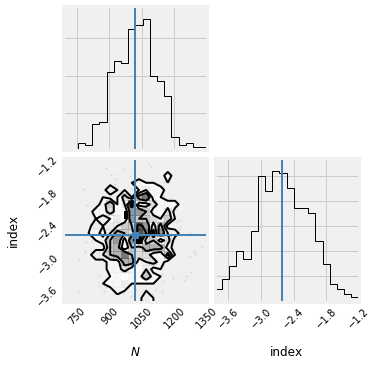

In [14]:
import corner
nwalkers = 500
ndim = 2 

range_n = [2000, 500]
range_index = [-2, -3]

p_a = np.random.normal(loc=N_HEGRA.value, scale=100, size=nwalkers) 
p_index = np.random.normal(loc=INDEX_HEGRA, scale=0.5,  size=nwalkers) 
p0 = np.vstack([p_a, p_index]).T

_ = corner.corner(p0, labels=['$N$', 'index'], truths=[N_HEGRA.value, INDEX_HEGRA])

In [15]:
import emcee

args  = [measured_counts_in_signal_region, measured_bkg_counts, bins, area.value, T_OBS.value]

sampler = emcee.EnsembleSampler(nwalkers, ndim, binned_poisson_likelihood, args=args, threads=4)
pos, prob, state = sampler.run_mcmc(p0, 50)
sampler.reset()
sampler.run_mcmc(pos, 300);
samples  = sampler.flatchain

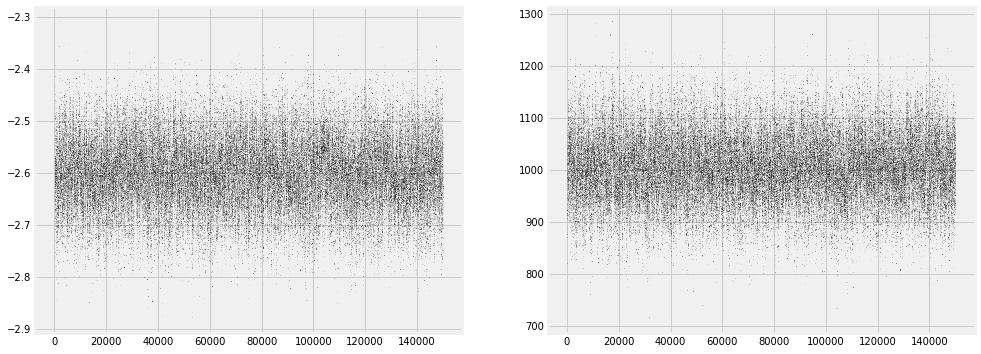

In [16]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 6))
ax1.plot(samples[:, 1], ',', color='k', alpha=0.1, )
ax2.plot(samples[:, 0], ',', color='k', alpha=0.1, )

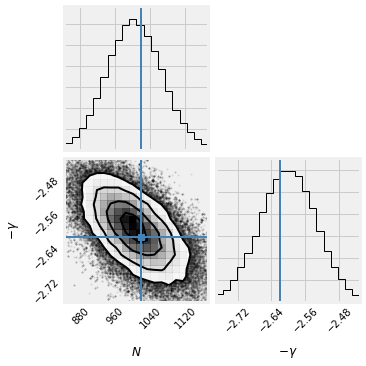

In [17]:
_ = corner.corner(samples,
                  labels=['$N$', '$-\gamma$'],
                  truths=[N_HEGRA.value, INDEX_HEGRA],
                  range=[0.99, 0.99]
                 )

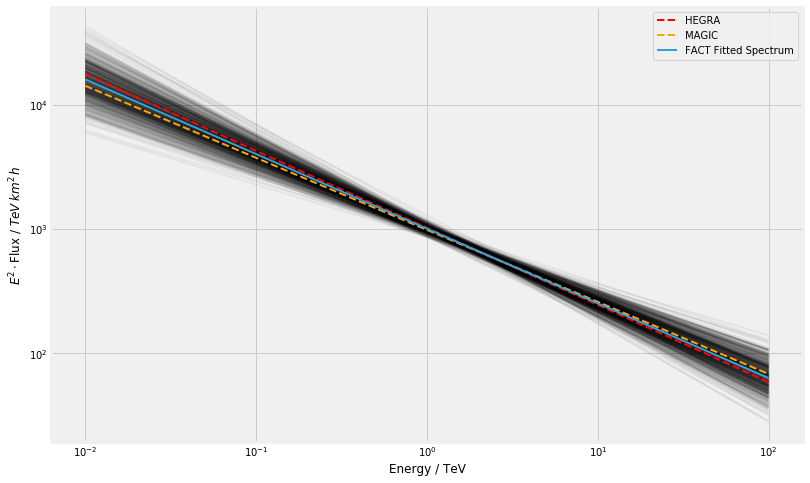

In [18]:
N_fit, index_fit = samples.mean(axis=0)

e = np.logspace(-2, 2, 50, base=10)
plt.figure(figsize=(12, 8))

for n, index in samples[np.random.randint(len(samples), size=500)]:
    plt.plot(e, e**2 * n * e **index, color='black', alpha=0.05)

h1, = plt.plot(e, e**2 * N_HEGRA * e **(INDEX_HEGRA) , '--', label='HEGRA ', color='red')
h2, = plt.plot(e, e**2 * N_MAGIC * e **(INDEX_MAGIC) , '--', label='MAGIC ', color='orange')
h3, = plt.plot(e, e**2 *  N_fit * e **(index_fit) , label='FACT Fitted Spectrum')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy / TeV')
plt.ylabel('$E^2 \cdot \mathrm{Flux}$ / $TeV\, km^2\, h$')
plt.legend()

In [19]:
n_mcmc, index_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))

from IPython.display import display, Math, Latex
print('Index:')
display(Math('{{{:6.3f}}}_{{{:6.4f}}}^{{{:6.4f}}}$'.format(*index_mcmc)))

print('Normalization:')
display(Math('{{{:0.5f}}}_{{{:0.6f}}}^{{{:0.6f}}}$'.format(*n_mcmc)))


Index:


<IPython.core.display.Math object>

Normalization:


<IPython.core.display.Math object>